In [16]:
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
from scipy import optimize
import matplotlib.pyplot as plt


In [2]:


# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I_params, t):
    I = I_params[0]*np.sin(I_params[1]*t)
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
dt = 0.01  # Time step (ms)
t = np.arange(0, 50, dt)  # Time vector (ms)


# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


In [3]:
def integrate_HH(V0, m, h, n, I_params, dt, t):
    
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record


    

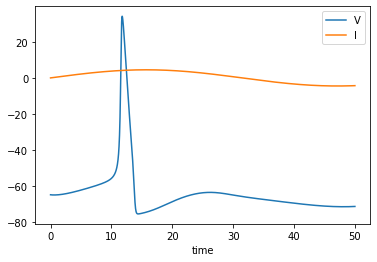

In [4]:
#A = 4.289
#w = 0.1
A = 4.5
w = 0.1

I_params = np.array([A, w])

V_record = integrate_HH(V0, m, h, n, I_params, dt, t)

I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, I_stimulus, label = 'I')
plt.xlabel('time')
plt.legend()

## Adjoint

#### Fake Data

In [ ]:
# #np.load('./sim_data/t_vec.p', allow_pickle = True)
# import pickle

# import neuron.hoc39
# #from neuron import h, gui
# t_file = './sim_data/t_vec.p'


# with open(t_file, mode='rb') as f:
#     t_data = pickle.load(f)


In [5]:
# run forward model to create fake data to test adjoint

V_subsamp = V_record[::10]
    
mean = np.mean(V_record)
stddev = np.std(V_record)

noise = np.random.normal(0, stddev, len(V_subsamp))
#noise = np.random.normal(0,1,len(V_subsamp))
V_data = V_subsamp + noise

data_steps = t[::10]

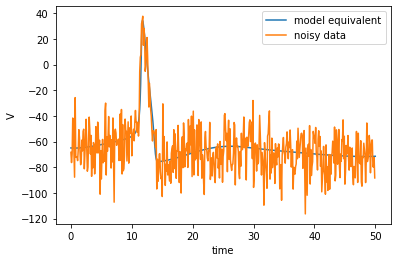

In [6]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(data_steps, V_data, label = 'noisy data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

#### Compute Gradient

In [7]:
def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # run forward step
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute model-data misfit
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2
            
    cost = cost/len(data_steps)
            
    #return V_record, cost
    return cost


        
        

In [8]:
# test

total_cost = forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data)
total_cost



array([216.4963744])

In [9]:
# find gradient

grad_AD = grad(forward_model_cost, 0) # 0 indicates differentiation w.r.t. the first argument of f.


In [10]:
# test autograd

grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)
#jac_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)

array([  -310.17406301, -11239.21618931])

#### FD Check

In [12]:
# FD check wrt A

A1 = np.random.uniform(0,5)
L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

p = np.random.randint(0,5000)
s = 1e-7 # step size
A2 = A1 + s*p
L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
dL_dV_p_diff = (L2 - L1) / s

g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
dL_dV_p = np.dot(g, p)

grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)


# # FD check wrt w

# w1 = np.random.uniform(0, 1)
# L1 = forward_model_cost(V0, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)

# p = np.random.randint(0,5000)
# s = 1e-7 # step size
# w2 = w1 + s*p
# L2 = forward_model_cost(V0, m, h, n, np.array([A, w2]), dt, t, data_steps, V_data)
# dL_dV_p_diff = (L2 - L1) / s

# g = grad_AD(V, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)[1]
# dL_dV_p = np.dot(g, p)

# grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# print('step size=', s, ', gradient finite difference error=', grad_err)





step size= 1e-07 , gradient finite difference error= [3.83089909e-06]


/Users/shoshi/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_68068/3132973727.py:32: RuntimeWarning: overflow encountered in scalar power
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_68068/3104993215.py:14: RuntimeWarning: invalid value encountered in scalar add
  V += dVdt * dt
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_68068/3132973727.py:32: RuntimeWarning: overflow encountered in scalar multiply
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_68068/3132973727.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L

step size= 1.0 , example gradient finite difference error= [nan]
step size= 0.1 , example gradient finite difference error= [nan]
step size= 0.01 , example gradient finite difference error= [1.22650383]
step size= 0.001 , example gradient finite difference error= [0.06480757]
step size= 0.0001 , example gradient finite difference error= [0.00615563]
step size= 1e-05 , example gradient finite difference error= [0.00061286]
step size= 1e-06 , example gradient finite difference error= [6.12591959e-05]
step size= 1e-07 , example gradient finite difference error= [6.125966e-06]
step size= 1e-08 , example gradient finite difference error= [6.0892553e-07]
step size= 1e-09 , example gradient finite difference error= [1.3578693e-08]
step size= 1e-10 , example gradient finite difference error= [1.64701075e-07]
step size= 1e-11 , example gradient finite difference error= [5.94525305e-06]
step size= 1e-12 , example gradient finite difference error= [6.86086301e-05]
step size= 1e-13 , example gradi

Text(0, 0.5, 'error')

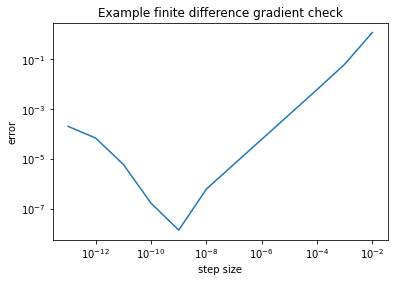

In [14]:
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

A1 = np.random.uniform(0,5)
L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# compute gradient using autograd
g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
dL_dV_p = np.dot(g, p)

# j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# dL_dV_p = np.dot(j, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    A2 = A1 + s*p

    L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')




# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# # Make log-log plot of gradient finite difference error vs. step size

# w1 = np.random.uniform(0, 1)
# L1 = forward_model_cost(V0, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)


# # compute gradient using autograd
# g = grad_AD(V, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)[1]
# dL_dV_p = np.dot(g, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     w2 = w1 + s*p

#     L2 = forward_model_cost(V0, m, h, n, np.array([A, w2]), dt, t, data_steps, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')



#### Find Minimizer

In [15]:
A, w

(4.5, 0.1)

In [21]:
# A = 4.289
# w = 0.1

initial_guess = np.array([A, w])

optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, method = 'BFGS')

optim


      fun: 212.2550553124437
 hess_inv: array([[ 2.71957721e-02, -9.56805674e-04],
       [-9.56805674e-04,  3.37237615e-05]])
      jac: array([-3.37859275e-06, -1.02195216e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 66
      nit: 13
     njev: 55
   status: 2
  success: False
        x: array([4.18658759, 0.11043133])

In [23]:
optim.x

array([4.18658759, 0.11043133])

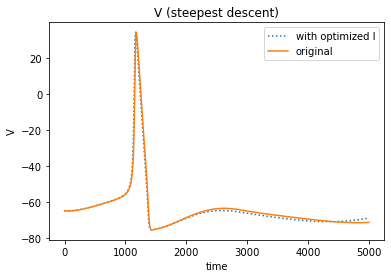

In [24]:
# norm_g = np.linalg.norm(g_func(Ak))
# print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

V_final = integrate_HH(V0, m, h, n, optim.x, dt, t)

plt.figure()
plt.plot(V_final, ls = 'dotted', label = 'with optimized I')
plt.plot(V_record, label = 'original')
plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()